# DINEOF

In [1]:
import autoroot
from jaxtyping import Float, Array
import numpy as np
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh
from da_toolz._src.ops.covariance import localize_covariance
from da_toolz._src.models.pca import pod_temporal_reconstruction, pod_svd_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

### Rearrange Data

In [4]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
ds = ds.stack(spatial=["lon", "lat"])

In [5]:
n_space = ds.spatial.shape[0]
n_time = ds.time.shape[0]

In [6]:
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, spatial: 1325)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * spatial  (spatial) object 11kB MultiIndex
  * lon      (spatial) float32 5kB 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat      (spatial) float32 5kB 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air      (time, spatial) float64 31MB -31.95 -29.35 -23.15 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Missing Data

In [7]:
def set_random_fraction_to_nan(data):
    data[np.random.rand(*data.shape) < .8]=np.nan
    return data

In [8]:
ds["air_obs"] = ds["air"].copy()

In [9]:
ds

<xarray.Dataset> Size: 62MB
Dimensions:  (time: 2920, spatial: 1325)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * spatial  (spatial) object 11kB MultiIndex
  * lon      (spatial) float32 5kB 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat      (spatial) float32 5kB 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air      (time, spatial) float64 31MB -31.95 -29.35 -23.15 ... 22.04 22.54
    air_obs  (time, spatial) float64 31MB -31.95 -29.35 -23.15 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [10]:
# Set 80% of data randomly to nan
dims = ['time','spatial']
ds["air_obs"] = xr.apply_ufunc(set_random_fraction_to_nan, ds["air_obs"], input_core_dims=[dims],output_core_dims=[dims], dask='parallelized')

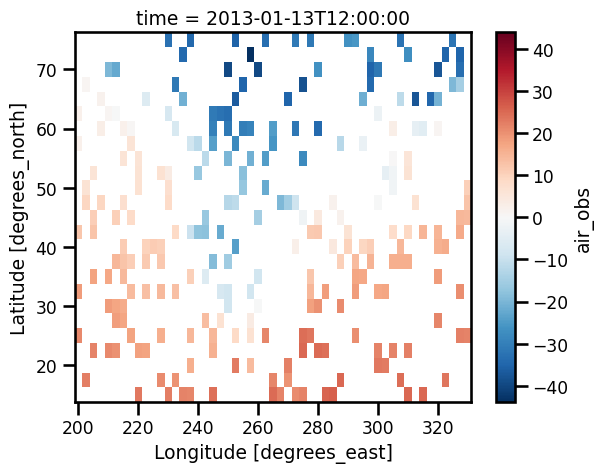

In [11]:
ds.air_obs.unstack().isel(time=50).plot.pcolormesh(x="lon")

## Initial Condition

In [37]:
data = ds["air_obs"]

data = data.transpose("spatial", "time")

In [38]:
nan_mask = np.isnan(data)
non_nan_mask = ~nan_mask

# data = data.fillna(value=0.0)
data = data.interpolate_na(dim="time", method="slinear", fill_value="extrapolate")



In [39]:
num_components = 250
num_iters = 500
err = 0.0
X = data.values.copy()

losses = []

pbar = trange(num_iters, desc='Reconstruction', leave=True)
for i in pbar:

    # apply PCA decomposition
    X_recon = pod_svd_reconstruction(X=X.copy(), n_components=num_components, random_state=42)

    # set reconstructed values
    X_recon[non_nan_mask] = X[non_nan_mask]

    err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[non_nan_mask].std()

    pbar.set_postfix(error=err_new, rel_error=abs(err_new - err))
    
    losses.append(err_new)

    err = err_new
    X = X_recon

Reconstruction:   0%|          | 0/500 [00:00<?, ?it/s]

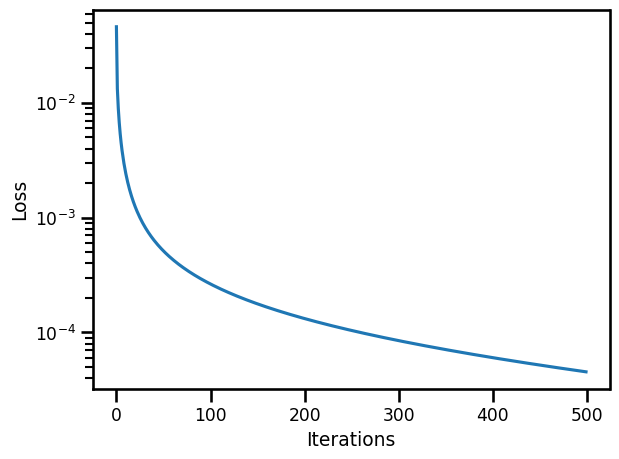

In [40]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

In [41]:
ds["air_new"] = (("spatial", "time"), X)

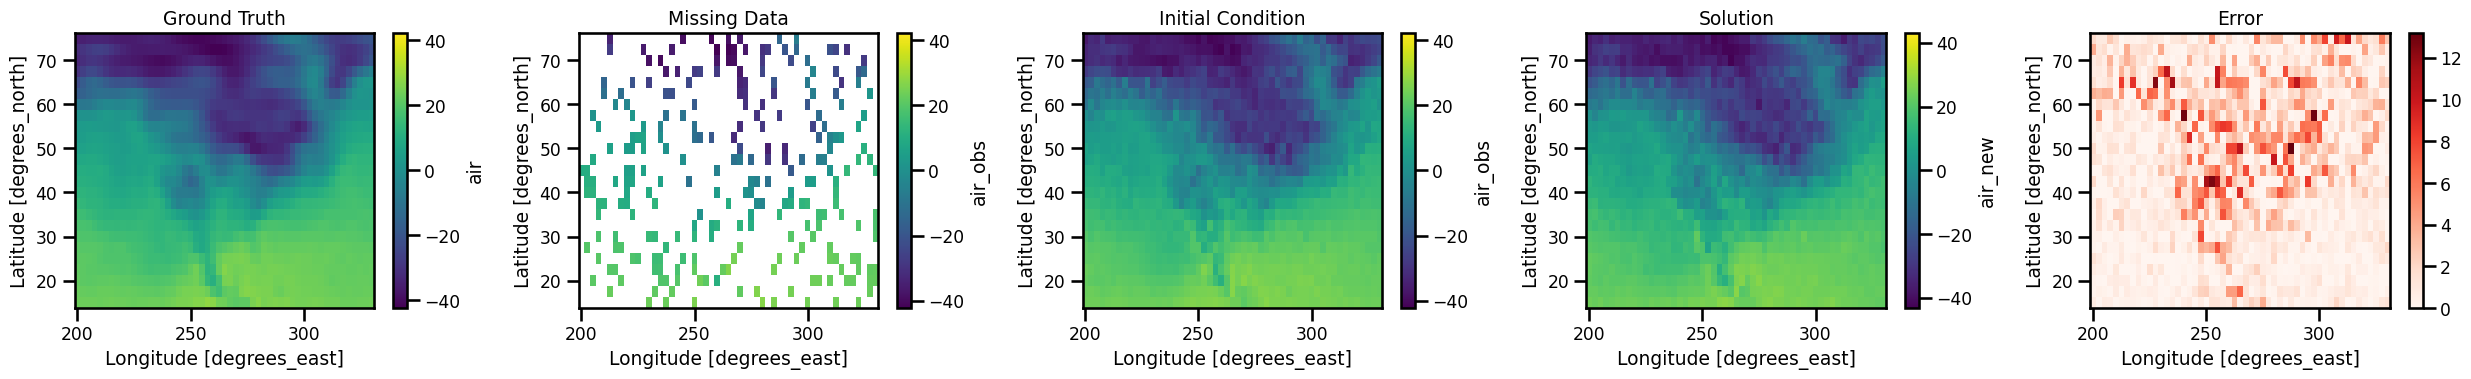

In [42]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))

itime = 150

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
data.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
ds.air_new.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
np.abs(ds.air.isel(time=itime) - ds.air_new.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")

ax[0].set(title="Ground Truth")
ax[1].set(title="Missing Data")
ax[2].set(title="Initial Condition")
ax[3].set(title="Solution")
ax[4].set(title="Error")
plt.tight_layout()
plt.show()

## Multi-Components

In [30]:
data = ds["air_obs"]

data = data.transpose("spatial", "time")

In [31]:
nan_mask = np.isnan(data)
non_nan_mask = ~nan_mask

# data = data.fillna(value=0.0)
data = data.interpolate_na(dim="time", method="slinear", fill_value="extrapolate")

In [33]:
X.shape

(1325, 2920)

In [34]:

num_iters = 250
num_components = [5, 10, 20, 30, 40, 50]
pbar_components = tqdm(num_components, desc="Components")

X = data.values.copy()

err = 0.0
losses = []
X_recons = {}
for n in pbar_components:
    pbar = trange(num_iters, desc='Reconstruction', leave=False)
    for i in pbar:

        # extract inputs
        # apply PCA decomposition
        X_recon = pod_svd_reconstruction(X=X.copy(), n_components=n, random_state=42)

        # set non reconstructed values
        X_recon[non_nan_mask] = X[non_nan_mask]

        err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[non_nan_mask].std()
        
        rel_error = abs(err_new - err)
        pbar.set_postfix(error=err_new, rel_error=rel_error)
        losses.append(err_new)
        if rel_error < 1e-10:
            break

        err = err_new
        X = X_recon.copy()
        X_recons[n] = X.copy()
    pbar_components.set_postfix(error=err_new, rel_error=abs(err_new - err))


Components:   0%|          | 0/7 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

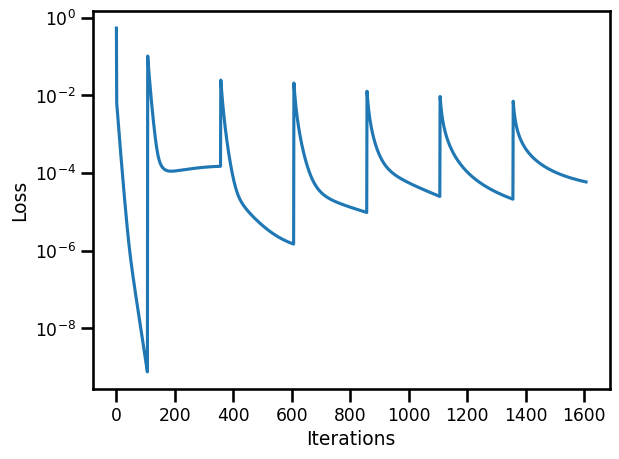

In [35]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

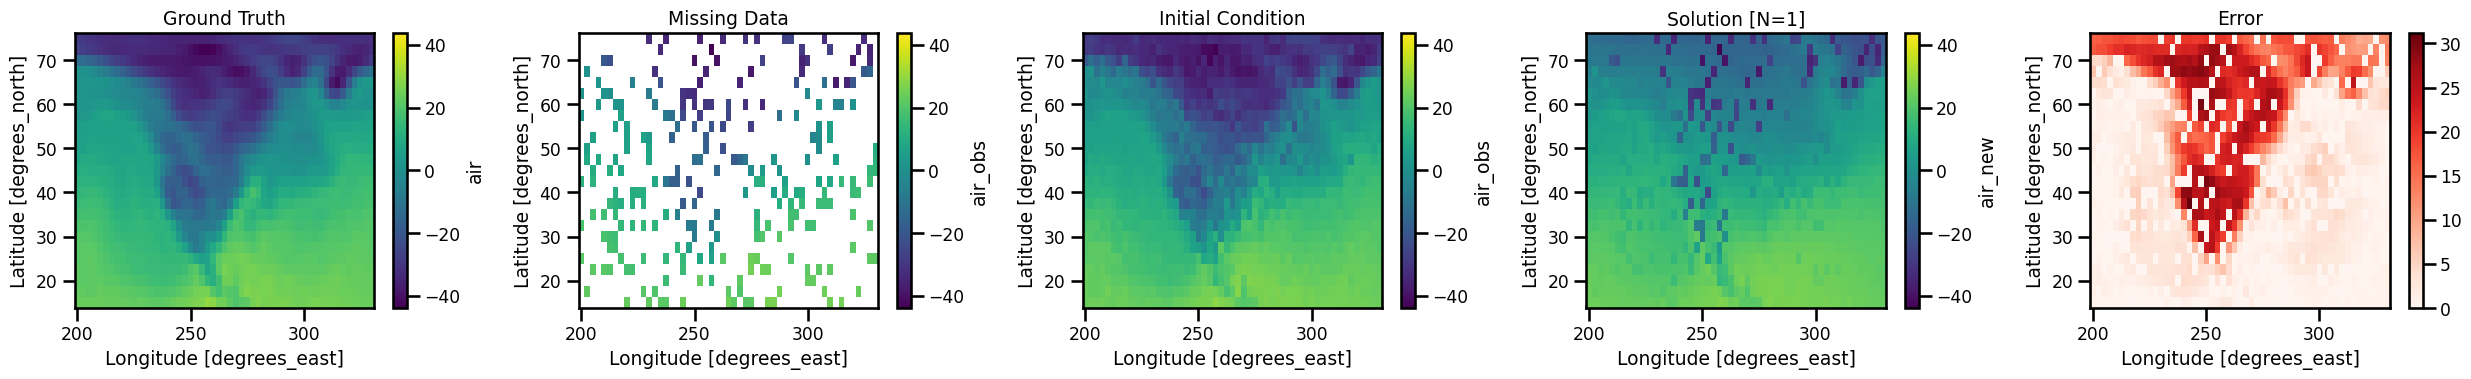

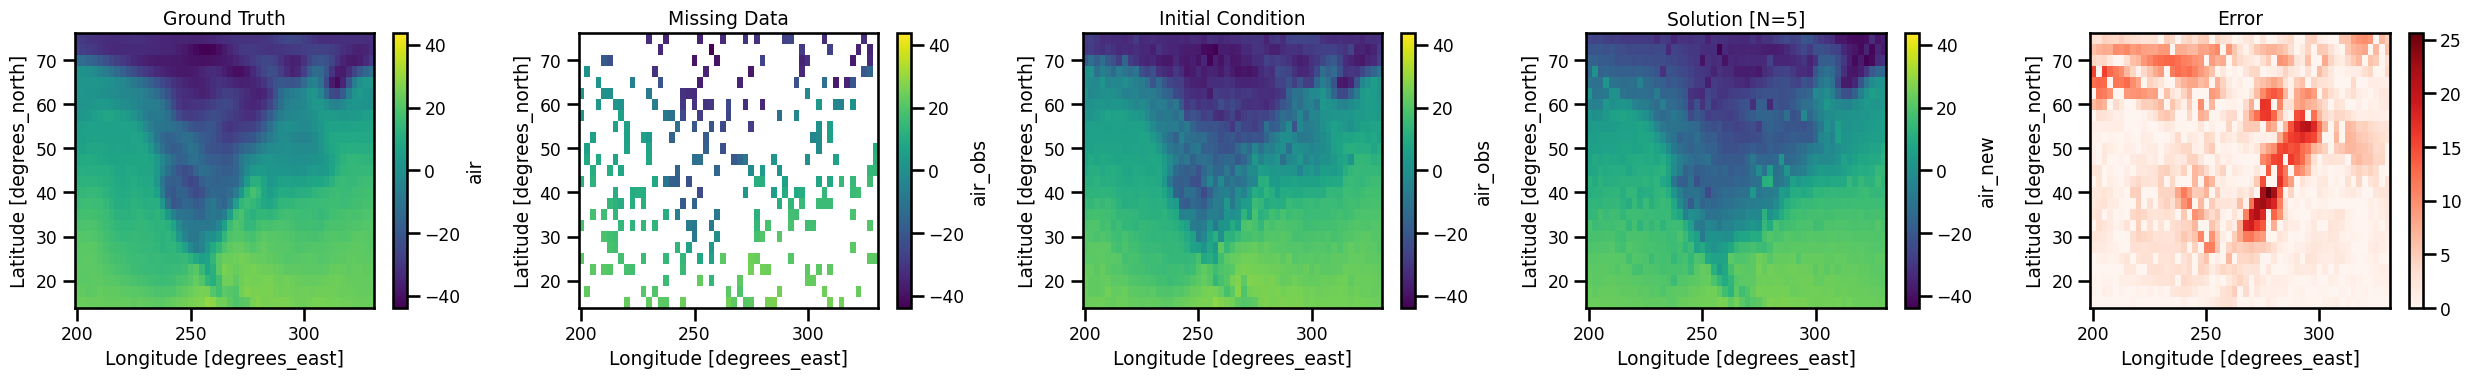

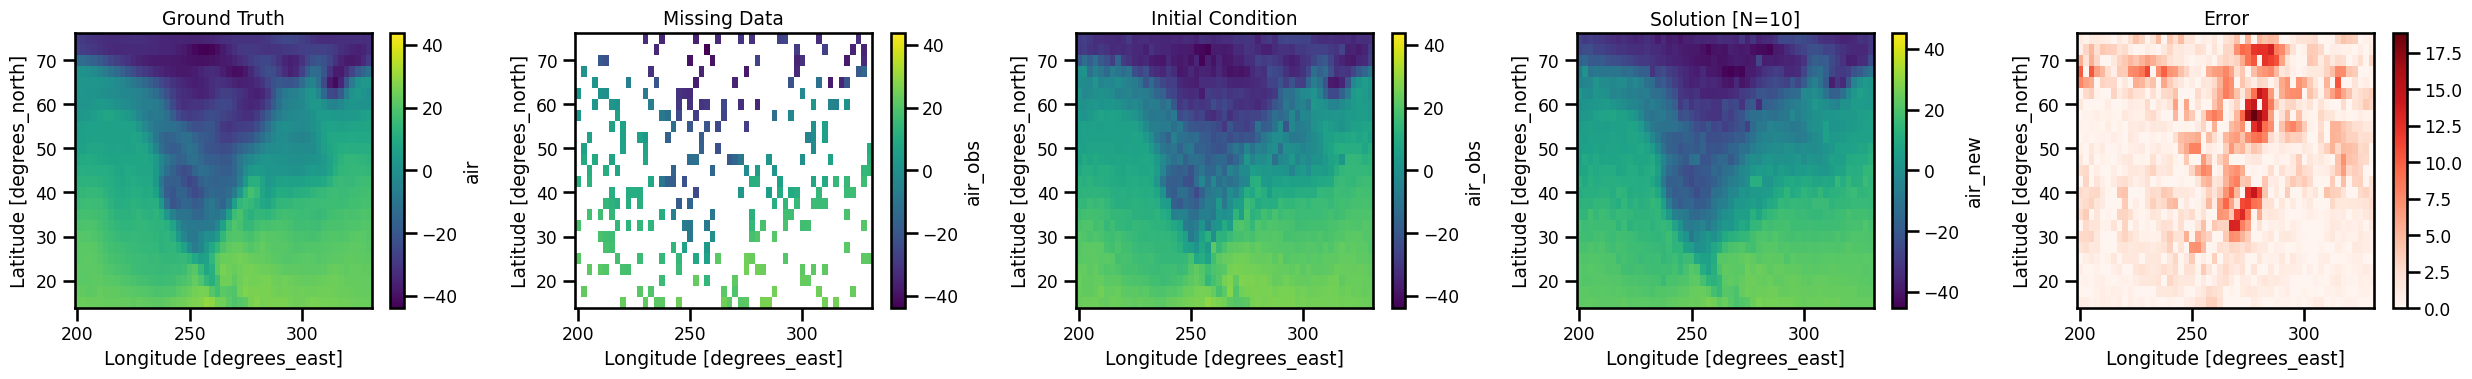

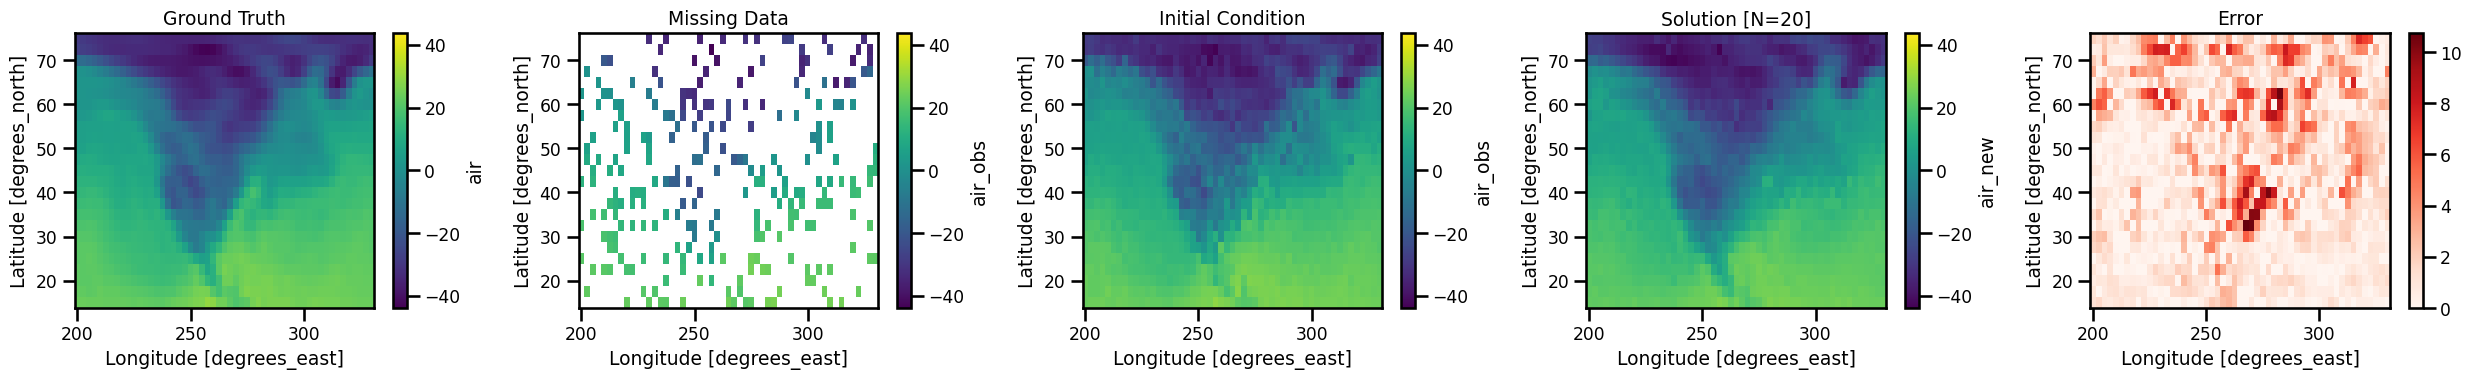

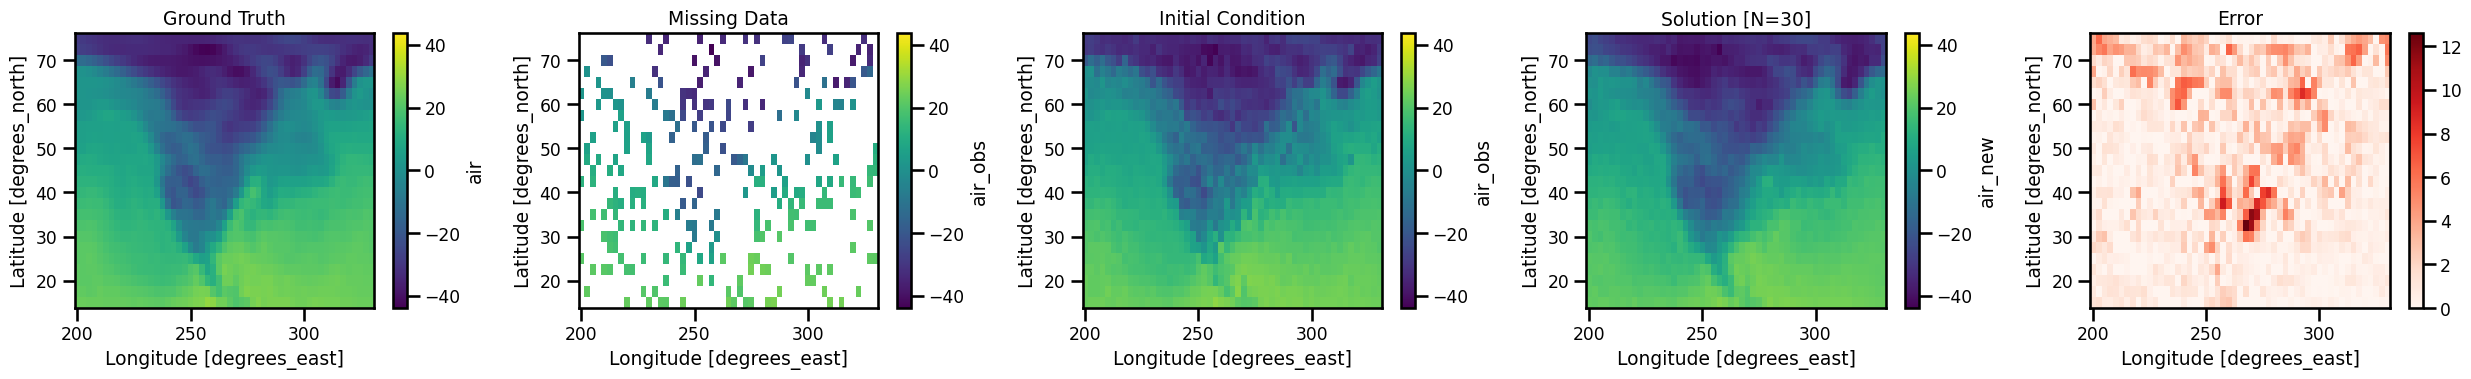

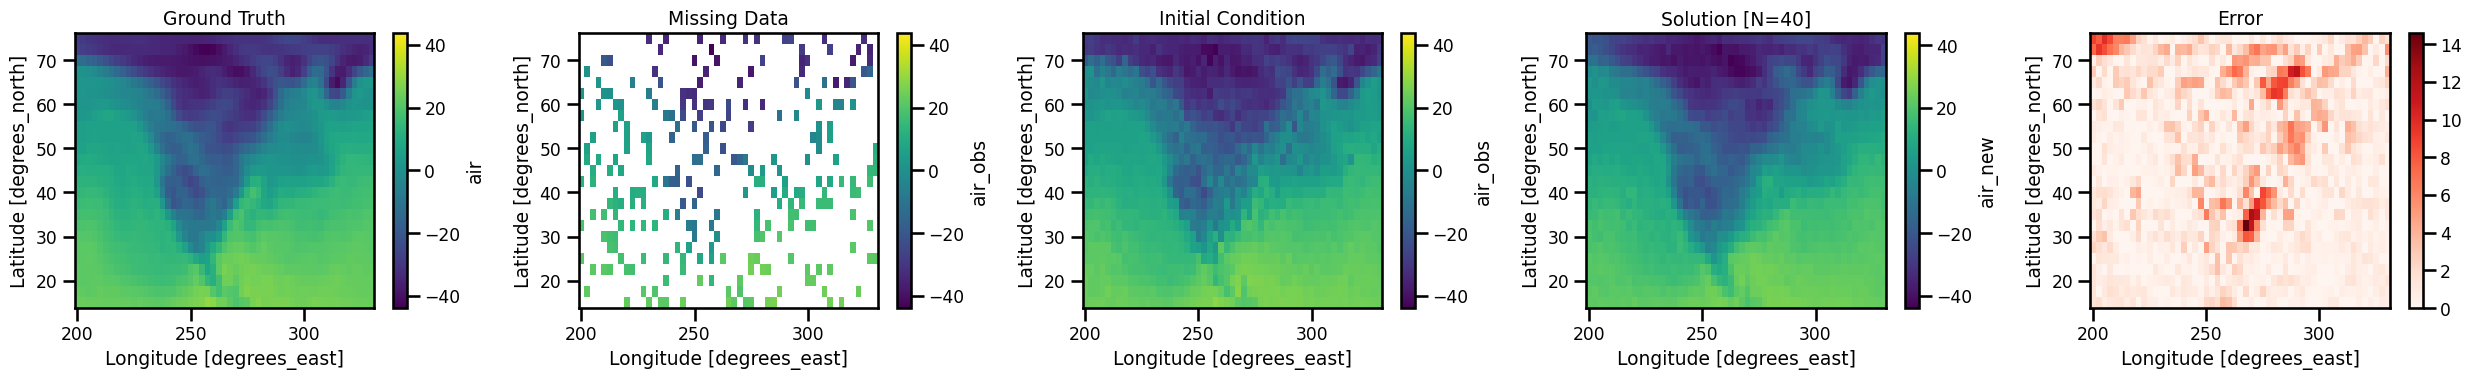

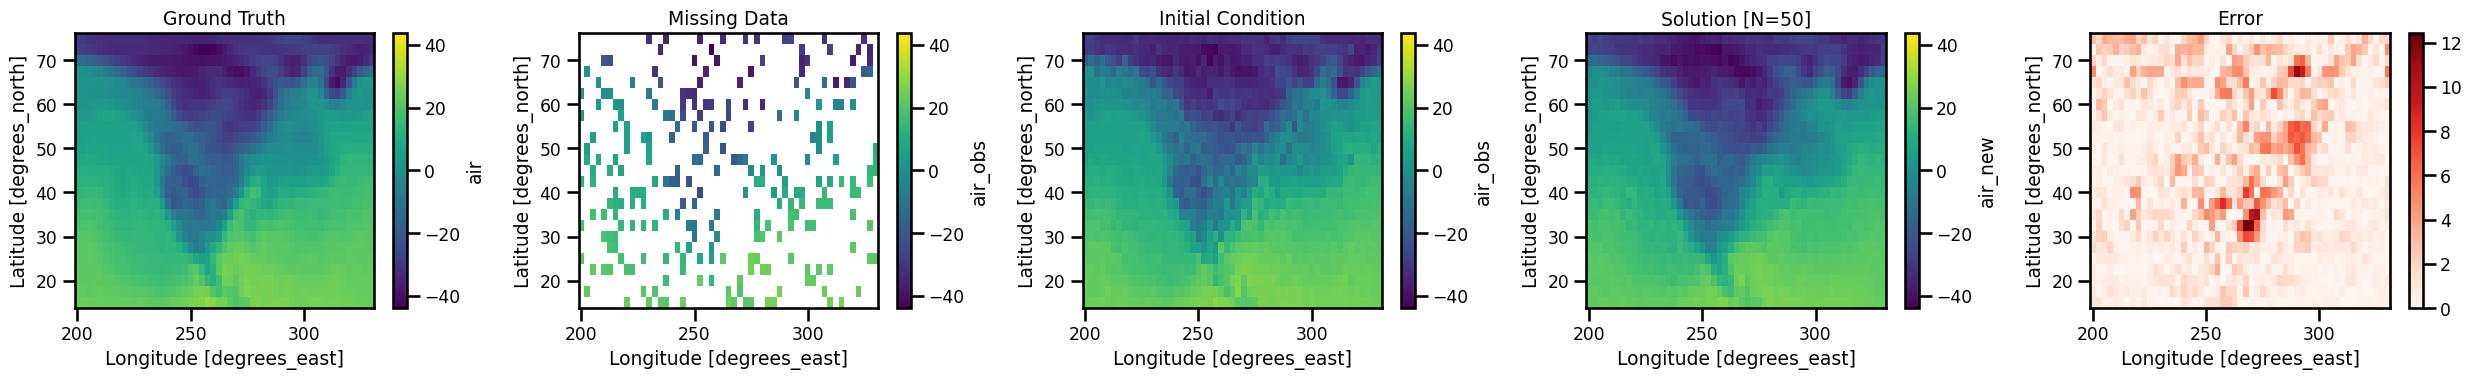

In [36]:

for i in num_components:

    fig, ax = plt.subplots(ncols=5, figsize=(25,4))

    ds["air_new"] = (("spatial", "time",), X_recons[i])

    itime = 50

    ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
    ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
    data.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
    ds.air_new.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
    np.abs(ds.air.isel(time=itime) - ds.air_new.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")

    ax[0].set(title="Ground Truth")
    ax[1].set(title="Missing Data")
    ax[2].set(title=f"Initial Condition")
    ax[3].set(title=f"Solution [N={i}]")
    ax[4].set(title="Error")
    plt.tight_layout()
    plt.show()